<b>Case description</b>: \
This is your first day as a data scientist at one of the world’s largest retail companies. Already on your first day, 
you are invited to a meeting with important business stakeholders from the online payment department, who ask 
for your help: Over the past year they have encountered a high failure rate of online credit card payments. The 
company loses a lot of money due to failed transactions and customers become increasingly unsatisfied with the 
online shop. \
Such online credit card payments are performed via so-called payment service providers, referred to as “PSPs” 
by the business stakeholders. Your company has contracts with four different PSPs and pays transaction fees for 
every single payment. \
The current routing logic is manual and rule-based. Business decision-makers, however, hope that with predictive 
modelling and with your help, a smarter way of routing a PSP to a transaction is possible.

<b>Project Aim</b>: \
Help the business to automate the credit card routing via a predictive model. Such a model should increase the 
payment success rate by finding the best possible PSP for each transaction and at the same time keep the 
transaction fees low

● Structure the project via the CRISP-DM or Team DS methodologies and give a recommendation of how a git 
repository for the project could look like. Note that you do not have to structure your final code according to 
your git-repository proposal.\
● Assess the quality of the provided data set. Prepare and visualize your findings of the initial data analysis 
in order that business stakeholders can understand them in a clear and easy way. \
● Provide a baseline model as well as an accurate predictive model, which fulfills business requirements, 
i.e. increase credit card success rate and keep fees low. \
● In order that the business places confidence in your model, discuss the importance of the individual features 
and make the results of the model interpretable. Moreover, a sophisticated error analysis is very important 
for the business to understand the drawbacks of your approach. \
● In the last step of the project, give a proposal of how your model could be used by the business in everyday 
work, for instance, via a graphical user interface (GUI).\
● Finally, do not forget to attach the code to the final submission document.\

<b>Column Description</b>: \
• tmsp: timestamp of transaction \
• country: country of transaction \
• amount: transaction amount \
• success: is 1 if payment is successful \
• PSP: name of payments service provider \
• 3D_secured: is 1 if customer is 3D identified (i.e. more secure online credit card payments) \
• card: credit card provider (Master, Visa, Diners) \

<b>Additional Info from Business Side</b>: \
Many transactions fail at the first try. Therefore, customers try several times to transfer the money. If two 
transactions are within one minute, with the same amount of money and from the same country, it is (for a decent number of tries) safe to assume that they are payment attempts of the same purchase. Consider this possibility of several payment attempts of the same purchase in your machine learning model



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('PSP_Jan_Feb_2019.csv')

In [3]:
data.shape

(50410, 7)

In [4]:
data.describe()

,amount,success,3D_secured
count,50410.000000,50410.000000,50410.000000
mean,202.395715,0.202896,0.238266
std,96.274730,0.402160,0.426027
min,6.000000,0.000000,0.000000
25%,133.000000,0.000000,0.000000
50%,201.000000,0.000000,0.000000
75%,269.000000,0.000000,0.000000
max,630.000000,1.000000,1.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tmsp        50410 non-null  object
 1   country     50410 non-null  object
 2   amount      50410 non-null  int64 
 3   success     50410 non-null  int64 
 4   PSP         50410 non-null  object
 5   3D_secured  50410 non-null  int64 
 6   card        50410 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.7+ MB


In [6]:
data['tmsp'] = pd.to_datetime(data['tmsp'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50410 non-null  datetime64[ns]
 1   country     50410 non-null  object        
 2   amount      50410 non-null  int64         
 3   success     50410 non-null  int64         
 4   PSP         50410 non-null  object        
 5   3D_secured  50410 non-null  int64         
 6   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.7+ MB


In [7]:
data.isnull().sum()

tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

In [8]:
# Calculate the success rate for each PSP grouped by country
success_rate = data.groupby(['country', 'card'])['success'].mean().reset_index()

# Rename the 'success' column to 'success_rate'
success_rate.rename(columns={'success': 'success_rate'}, inplace=True)

print(success_rate)

       country    card  success_rate
0      Austria  Diners      0.236118
1      Austria  Master      0.196316
2      Austria    Visa      0.198463
3      Germany  Diners      0.218723
4      Germany  Master      0.192793
5      Germany    Visa      0.208416
6  Switzerland  Diners      0.222541
7  Switzerland  Master      0.194757
8  Switzerland    Visa      0.218143


In [9]:
# Merge the success_rate dataframe with the original data to add the success_rate feature
data = data.merge(success_rate, on=['country', 'card'], how='left')

# Display the updated dataframe
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118


In [10]:
from math import ceil
# Create a new feature 'week_of_month' to extract the week number of the month from the timestamp
def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

data['week_of_month'] = data['tmsp'].apply(week_of_month)

# Display the first few rows to verify the new feature
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1


In [11]:
country_success_rate = data.groupby('country')['success'].mean().reset_index()

# Create a new feature 'high_amount' to indicate if the transaction amount is above a certain threshold (e.g., 200)
data['high_amount'] = data['amount'] > 200

# Create a new feature 'hour' to extract the hour of the day from the timestamp
data['hour'] = data['tmsp'].dt.hour

# Display the first few rows to verify the new features
# data.head()
# Create a new feature 'is_weekend' to indicate if the transaction occurred on a weekend
data['is_weekend'] = data['tmsp'].dt.weekday >= 5

# Create a new feature 'is_high_success_country' to indicate if the transaction is from a high success rate country
high_success_countries = country_success_rate[country_success_rate['success'] > 0.2]['country']
data['is_high_success_country'] = data['country'].isin(high_success_countries)

# Display the first few rows to verify the new features
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True


In [12]:
# Create a new feature 'transaction_hour' to categorize transactions into different time periods of the day
def categorize_hour(hour):
    if 0 <= hour < 6:
        return 'Midnight'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

data['transaction_hour'] = data['hour'].apply(categorize_hour)

# Create a new feature 'amount_category' to categorize transaction amounts into different ranges
def categorize_amount(amount):
    if amount < 133:
        return 'Low'
    elif 133 <= amount < 201:
        return 'Medium'
    else:
        return 'High'

data['amount_category'] = data['amount'].apply(categorize_amount)

# Display the first few rows to verify the new features
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low


In [13]:
# Create a 'success_fee' column based on the conditions provided
def calculate_success_fee(row):
    if row['PSP'] == 'Moneycard' and row['success'] == 1:
        return 5
    elif row['PSP'] == 'Goldcard' and row['success'] == 1:
        return 10
    elif row['PSP'] == 'UK_Card' and row['success'] == 1:
        return 3
    elif row['PSP'] == 'Simplecard' and row['success'] == 1:
        return 1
    elif row['PSP'] == 'Moneycard' and row['success'] == 0:
        return 2
    elif row['PSP'] == 'Goldcard' and row['success'] == 0:
        return 5
    elif row['PSP'] == 'UK_Card' and row['success'] == 0:
        return 1
    elif row['PSP'] == 'Simplecard' and row['success'] == 0:
        return 0.5
    else:
        return 0

data['transaction_fee'] = data.apply(calculate_success_fee, axis=1)

# Display the first few rows to verify the new column
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category,transaction_fee
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,1.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,3.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,1.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,3.0
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low,0.5


In [14]:
data['weekday'] = data['tmsp'].dt.day_name()
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category,transaction_fee,weekday
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,1.0,Tuesday
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,3.0,Tuesday
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,1.0,Tuesday
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,3.0,Tuesday
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low,0.5,Tuesday


In [15]:
data.shape

(50410, 17)

In [16]:
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category,transaction_fee,weekday
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,1.0,Tuesday
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,3.0,Tuesday
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,1.0,Tuesday
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,3.0,Tuesday
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low,0.5,Tuesday


In [17]:
# Calculate the success rate with respect to the 3D secured column for each country
secured_success_rate = data.groupby(['country', 'card','3D_secured'])['success'].mean().reset_index()

# Rename the 'success' column to 'secured_success'
secured_success_rate.rename(columns={'success': 'secured_success_rate_of_card'}, inplace=True)

# Merge the secured_success_rate dataframe with the original data to add the secured_success feature
data = data.merge(secured_success_rate, on=['country', 'card','3D_secured'], how='left')

# Display the updated dataframe
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category,transaction_fee,weekday,secured_success_rate_of_card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,1.0,Tuesday,0.184538
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,3.0,Tuesday,0.184538
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,1.0,Tuesday,0.235252
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,3.0,Tuesday,0.235252
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low,0.5,Tuesday,0.236389


In [18]:
# data.drop('secured_success_rate_of_PSP_x', axis =1,inplace=True)  

In [19]:
# Rename the column 'PSP_x' to 'PSP'
# data.rename(columns={'PSP_x': 'PSP'}, inplace=True)

# Display the updated dataframe to verify the change
# data.head()

In [20]:
data.shape

(50410, 18)

In [21]:
# Calculate the success rate for each PSP grouped by country
country_psp_success_rate = data.groupby(['country', 'PSP'])['success'].mean().reset_index()

# Rename the 'success' column to 'country_psp_success_rate'
country_psp_success_rate.rename(columns={'success': 'country_psp_success_rate'}, inplace=True)

# Merge the country_psp_success_rate dataframe with the original data to add the country_psp_success_rate feature
data = data.merge(country_psp_success_rate, on=['country', 'PSP'], how='left')

# Display the updated dataframe
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category,transaction_fee,weekday,secured_success_rate_of_card,country_psp_success_rate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,1.0,Tuesday,0.184538,0.193926
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,3.0,Tuesday,0.184538,0.193926
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,1.0,Tuesday,0.235252,0.193926
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,3.0,Tuesday,0.235252,0.193926
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low,0.5,Tuesday,0.236389,0.158658


In [22]:
# Filter the data to get the success rate of UK_Card in Germany
uk_card_germany_successrate = data[(data['PSP'] == 'UK_Card') & (data['country'] == 'Germany')]['success'].mean()

# Add the success rate as a new column to the dataframe
data['uk_card_germany_successrate'] = uk_card_germany_successrate

# Display the updated dataframe to verify the new column
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category,transaction_fee,weekday,secured_success_rate_of_card,country_psp_success_rate,uk_card_germany_successrate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,1.0,Tuesday,0.184538,0.193926,0.193926
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,3.0,Tuesday,0.184538,0.193926,0.193926
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,1.0,Tuesday,0.235252,0.193926,0.193926
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,3.0,Tuesday,0.235252,0.193926,0.193926
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low,0.5,Tuesday,0.236389,0.158658,0.193926


In [23]:
data.PSP.unique()

array(['UK_Card', 'Simplecard', 'Moneycard', 'Goldcard'], dtype=object)

In [24]:
# Create a new feature 'uk_card_germany_successrate' based on the condition
uk_card_germany_successrate = data[(data['PSP'] == 'UK_Card') & (data['country'] == 'Germany')]['success'].mean()
data['uk_card_germany_successrate'] = data.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'UK_Card' else 0, axis=1
)

uk_card_autria_successrate = data[(data['PSP'] == 'UK_Card') & (data['country'] == 'Austria')]['success'].mean()
data['uk_card_Austria_successrate'] = data.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Austria' and row['PSP'] == 'UK_Card' else 0, axis=1
)

uk_card_swiz_successrate = data[(data['PSP'] == 'UK_Card') & (data['country'] == 'Switzerland')]['success'].mean()
data['uk_card_swiz_successrate'] = data.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'UK_Card' else 0, axis=1
)

# Display the updated dataframe to verify the new feature
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,...,is_high_success_country,transaction_hour,amount_category,transaction_fee,weekday,secured_success_rate_of_card,country_psp_success_rate,uk_card_germany_successrate,uk_card_Austria_successrate,uk_card_swiz_successrate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,...,True,Midnight,Low,1.0,Tuesday,0.184538,0.193926,0.193926,0.0,0.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,...,True,Midnight,Low,3.0,Tuesday,0.184538,0.193926,0.193926,0.0,0.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,...,True,Midnight,High,1.0,Tuesday,0.235252,0.193926,0.193926,0.0,0.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,...,True,Midnight,High,3.0,Tuesday,0.235252,0.193926,0.193926,0.0,0.0
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,...,True,Midnight,Low,0.5,Tuesday,0.236389,0.158658,0.000000,0.0,0.0


In [25]:
# Create a new feature 'uk_card_germany_successrate' based on the condition
simplecard_germany_successrate = data[(data['PSP'] == 'Simplecard') & (data['country'] == 'Germany')]['success'].mean()
data['simplecard_germany_successrate'] = data.apply(
    lambda row: simplecard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Simplecard' else 0, axis=1
)

simplecard_autria_successrate = data[(data['PSP'] == 'Simplecard') & (data['country'] == 'Austria')]['success'].mean()
data['simplecard_austria_successrate'] = data.apply(
    lambda row: simplecard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Simplecard' else 0, axis=1
)

simplecard_swiz_successrate = data[(data['PSP'] == 'Simplecard') & (data['country'] == 'Switzerland')]['success'].mean()
data['simplecard_swiz_successrate'] = data.apply(
    lambda row: simplecard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Simplecard' else 0, axis=1
)

# Display the updated dataframe to verify the new feature
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,...,transaction_fee,weekday,secured_success_rate_of_card,country_psp_success_rate,uk_card_germany_successrate,uk_card_Austria_successrate,uk_card_swiz_successrate,simplecard_germany_successrate,simplecard_austria_successrate,simplecard_swiz_successrate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,...,1.0,Tuesday,0.184538,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,...,3.0,Tuesday,0.184538,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,...,1.0,Tuesday,0.235252,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,...,3.0,Tuesday,0.235252,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,...,0.5,Tuesday,0.236389,0.158658,0.000000,0.0,0.0,0.0,0.158658,0.0


In [26]:
# Create a new feature 'uk_card_germany_successrate' based on the condition
moneycard_germany_successrate = data[(data['PSP'] == 'Moneycard') & (data['country'] == 'Germany')]['success'].mean()
data['moneycard_germany_successrate'] = data.apply(
    lambda row: moneycard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Moneycard' else 0, axis=1
)

moneycard_autria_successrate = data[(data['PSP'] == 'Moneycard') & (data['country'] == 'Austria')]['success'].mean()
data['moneycard_Austria_successrate'] = data.apply(
    lambda row: moneycard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Moneycard' else 0, axis=1
)

moneycard_swiz_successrate = data[(data['PSP'] == 'Moneycard') & (data['country'] == 'Switzerland')]['success'].mean()
data['moneycard_swiz_successrate'] = data.apply(
    lambda row: moneycard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Moneycard' else 0, axis=1
)

# Display the updated dataframe to verify the new feature
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,...,country_psp_success_rate,uk_card_germany_successrate,uk_card_Austria_successrate,uk_card_swiz_successrate,simplecard_germany_successrate,simplecard_austria_successrate,simplecard_swiz_successrate,moneycard_germany_successrate,moneycard_Austria_successrate,moneycard_swiz_successrate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,...,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,...,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,...,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,...,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,...,0.158658,0.000000,0.0,0.0,0.0,0.158658,0.0,0.0,0.0,0.0


In [27]:
# Create a new feature 'uk_card_germany_successrate' based on the condition
goldcard_germany_successrate = data[(data['PSP'] == 'Goldcard') & (data['country'] == 'Germany')]['success'].mean()
data['moneycard_germany_successrate'] = data.apply(
    lambda row: goldcard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Goldcard' else 0, axis=1
)

goldcard_autria_successrate = data[(data['PSP'] == 'Goldcard') & (data['country'] == 'Austria')]['success'].mean()
data['moneycard_Austria_successrate'] = data.apply(
    lambda row: goldcard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Goldcard' else 0, axis=1
)

goldcard_swiz_successrate = data[(data['PSP'] == 'Goldcard') & (data['country'] == 'Switzerland')]['success'].mean()
data['moneycard_swiz_successrate'] = data.apply(
    lambda row: goldcard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Goldcard' else 0, axis=1
)

# Display the updated dataframe to verify the new feature
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,...,country_psp_success_rate,uk_card_germany_successrate,uk_card_Austria_successrate,uk_card_swiz_successrate,simplecard_germany_successrate,simplecard_austria_successrate,simplecard_swiz_successrate,moneycard_germany_successrate,moneycard_Austria_successrate,moneycard_swiz_successrate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,...,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,...,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,...,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,...,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,...,0.158658,0.000000,0.0,0.0,0.0,0.158658,0.0,0.0,0.0,0.0


In [28]:
# Calculate the success rate with respect to the 3D secured column for each PSP
psp_secured_success_rate = data.groupby(['3D_secured'])['success'].mean().reset_index()

# Rename the 'success' column to 'psp_secured_success_rate'
psp_secured_success_rate.rename(columns={'success': 'secured_success_rate'}, inplace=True)

# Merge the psp_secured_success_rate dataframe with the original data to add the psp_secured_success_rate feature
data = data.merge(psp_secured_success_rate, on=['3D_secured'], how='left')

# Display the updated dataframe
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,...,uk_card_germany_successrate,uk_card_Austria_successrate,uk_card_swiz_successrate,simplecard_germany_successrate,simplecard_austria_successrate,simplecard_swiz_successrate,moneycard_germany_successrate,moneycard_Austria_successrate,moneycard_swiz_successrate,secured_success_rate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.189562
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.189562
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.245525
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.245525
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,...,0.000000,0.0,0.0,0.0,0.158658,0.0,0.0,0.0,0.0,0.189562


## EDA

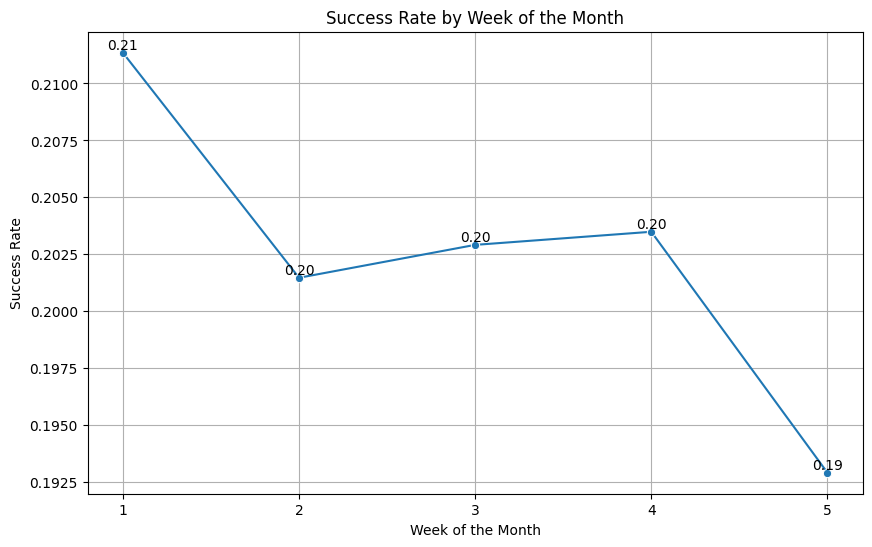

In [29]:
# Calculate the success rate for each week of the month
week_of_month_success_rate = data.groupby('week_of_month')['success'].mean().reset_index()

# Plot the success rate by week of the month and print the numbers on the graph
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='week_of_month', y='success', data=week_of_month_success_rate, marker='o')
plt.title('Success Rate by Week of the Month')
plt.xlabel('Week of the Month')
plt.ylabel('Success Rate')
plt.xticks(range(1, 6))  # Assuming there are up to 5 weeks in a month
plt.grid(True)

# Annotate the success rate on the graph
for x, y in zip(week_of_month_success_rate['week_of_month'], week_of_month_success_rate['success']):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.show()

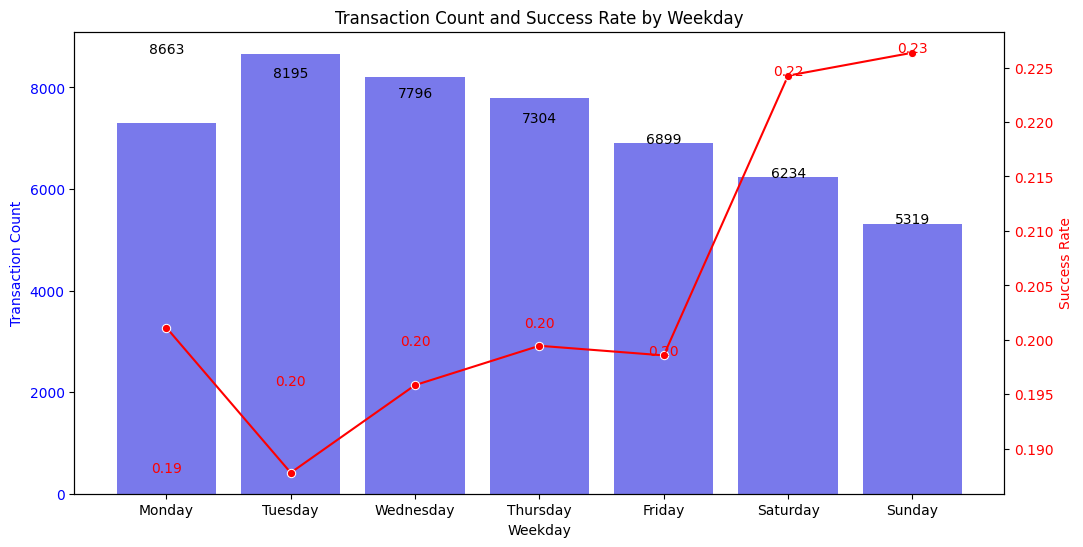

In [31]:
# Calculate the transaction count for each weekday
weekday_transaction_count = data['weekday'].value_counts().reset_index()
weekday_transaction_count.columns = ['weekday', 'transaction_count']

# Calculate the success rate for each weekday
weekday_success_rate = data.groupby('weekday')['success'].mean().reset_index()

# Merge the transaction count with the success rate
weekday_data = pd.merge(weekday_transaction_count, weekday_success_rate, on='weekday')

# Sort the data by weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_data['weekday'] = pd.Categorical(weekday_data['weekday'], categories=weekday_order, ordered=True)
weekday_data = weekday_data.sort_values('weekday')

# Plot the transaction count and success rate
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot transaction count
sns.barplot(x='weekday', y='transaction_count', data=weekday_data, ax=ax1, color='b', alpha=0.6)
ax1.set_xlabel('Weekday')
ax1.set_ylabel('Transaction Count', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Annotate the transaction count on the bar plot
for index, row in weekday_data.iterrows():
    ax1.text(row.name, row.transaction_count, row.transaction_count, color='black', ha="center")

# Create a secondary y-axis to plot the success rate
ax2 = ax1.twinx()
sns.lineplot(x='weekday', y='success', data=weekday_data, ax=ax2, color='r', marker='o')
ax2.set_ylabel('Success Rate', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Annotate the success rate on the line plot
for index, row in weekday_data.iterrows():
    ax2.text(row.name, row.success, f'{row.success:.2f}', color='red', ha="center")

plt.title('Transaction Count and Success Rate by Weekday')
plt.show()

In [32]:
week_of_month_transaction_count = data['week_of_month'].value_counts().reset_index()
week_of_month_transaction_count.columns = ['week_of_month', 'transaction_count']

# Merge the transaction count with the success rate
week_of_month_data = pd.merge(week_of_month_transaction_count, week_of_month_success_rate, on='week_of_month')

# Sort the data by week of the month
week_of_month_data = week_of_month_data.sort_values('week_of_month')

In [46]:
# # Plot the transaction count and success rate for each week of the month
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot transaction count
# sns.barplot(x='week_of_month', y='transaction_count', data=week_of_month_data, ax=ax1, color='b', alpha=0.6)
# ax1.set_xlabel('Week of the Month')
# ax1.set_ylabel('Transaction Count', color='b')
# ax1.tick_params(axis='y', labelcolor='b')

# # Create a secondary y-axis to plot the success rate
# ax2 = ax1.twinx()
# sns.lineplot(x='week_of_month', y='success', data=week_of_month_data, ax=ax2, color='r', marker='o')
# ax2.set_ylabel('Success Rate', color='r')
# ax2.tick_params(axis='y', labelcolor='r')

# plt.title('Transaction Count and Success Rate by Week of the Month')
# plt.show()

In [33]:
# # Plot the transaction count and success rate for each week of the month
# week_of_month_transaction_count = data['week_of_month'].value_counts().reset_index()
# week_of_month_transaction_count.columns = ['week_of_month', 'transaction_count']

# # Merge the transaction count with the success rate
# week_of_month_data = pd.merge(week_of_month_transaction_count, week_of_month_success_rate, on='week_of_month')

# # Sort the data by week of the month
# week_of_month_data = week_of_month_data.sort_values('week_of_month')


# # Plot the transaction count and success rate
# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot transaction count
# sns.barplot(x='week_of_month', y='transaction_count', data=week_of_month_data, ax=ax1, color='b', alpha=0.6)
# ax1.set_xlabel('Week of the Month')
# ax1.set_ylabel('Transaction Count', color='b')
# ax1.tick_params(axis='y', labelcolor='b')

# # Create a secondary y-axis to plot the success rate
# ax2 = ax1.twinx()
# sns.lineplot(x='week_of_month', y='success', data=week_of_month_data, ax=ax2, color='r', marker='o')
# ax2.set_ylabel('Success Rate', color='r')
# ax2.tick_params(axis='y', labelcolor='r')

# plt.title('Transaction Count and Success Rate by Week of the Month')
# plt.show()

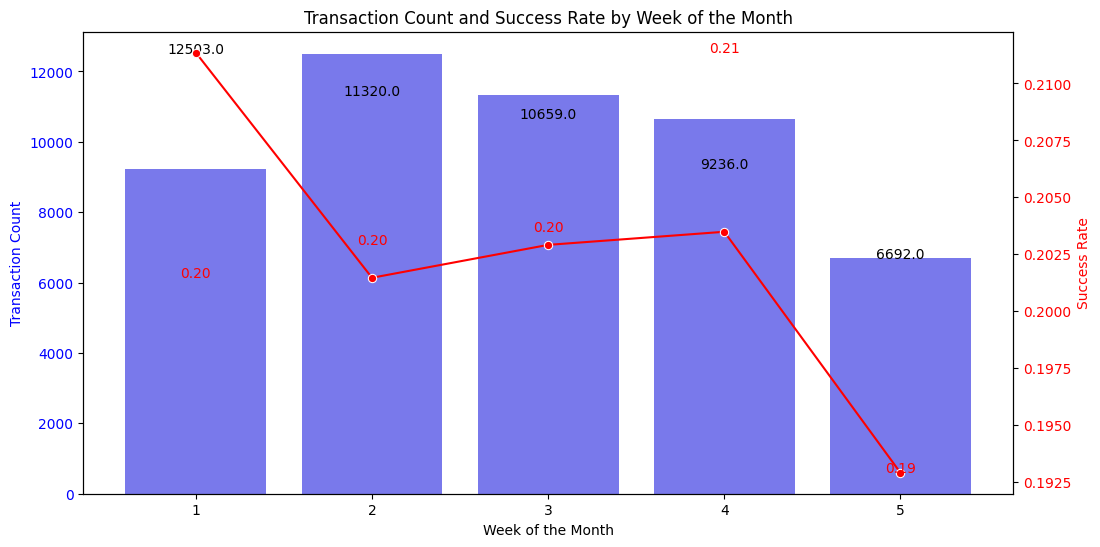

In [34]:
# Calculate the transaction count for each week of the month
week_of_month_transaction_count = data['week_of_month'].value_counts().reset_index()
week_of_month_transaction_count.columns = ['week_of_month', 'transaction_count']

# Calculate the success rate for each week of the month
week_of_month_success_rate = data.groupby('week_of_month')['success'].mean().reset_index()

# Merge the transaction count with the success rate
week_of_month_data = pd.merge(week_of_month_transaction_count, week_of_month_success_rate, on='week_of_month')

# Sort the data by week of the month
week_of_month_data = week_of_month_data.sort_values('week_of_month')

# Plot the transaction count and success rate
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot transaction count (bar plot)
sns.barplot(x='week_of_month', y='transaction_count', data=week_of_month_data, ax=ax1, color='b', alpha=0.6)
ax1.set_xlabel('Week of the Month')
ax1.set_ylabel('Transaction Count', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Annotate the transaction count on the bar plot
for index, row in week_of_month_data.iterrows():
    ax1.text(row.name, row.transaction_count, row.transaction_count, color='black', ha="center")

# Create a secondary y-axis to plot the success rate
ax2 = ax1.twinx()
sns.lineplot(x=week_of_month_data['week_of_month'] - 1, y=week_of_month_data['success'], ax=ax2, color='r', marker='o')
ax2.set_ylabel('Success Rate', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Annotate the success rate on the line plot
for index, row in week_of_month_data.iterrows():
    ax2.text(row.name, row.success, f'{row.success:.2f}', color='red', ha="center")

plt.title('Transaction Count and Success Rate by Week of the Month')
plt.show()

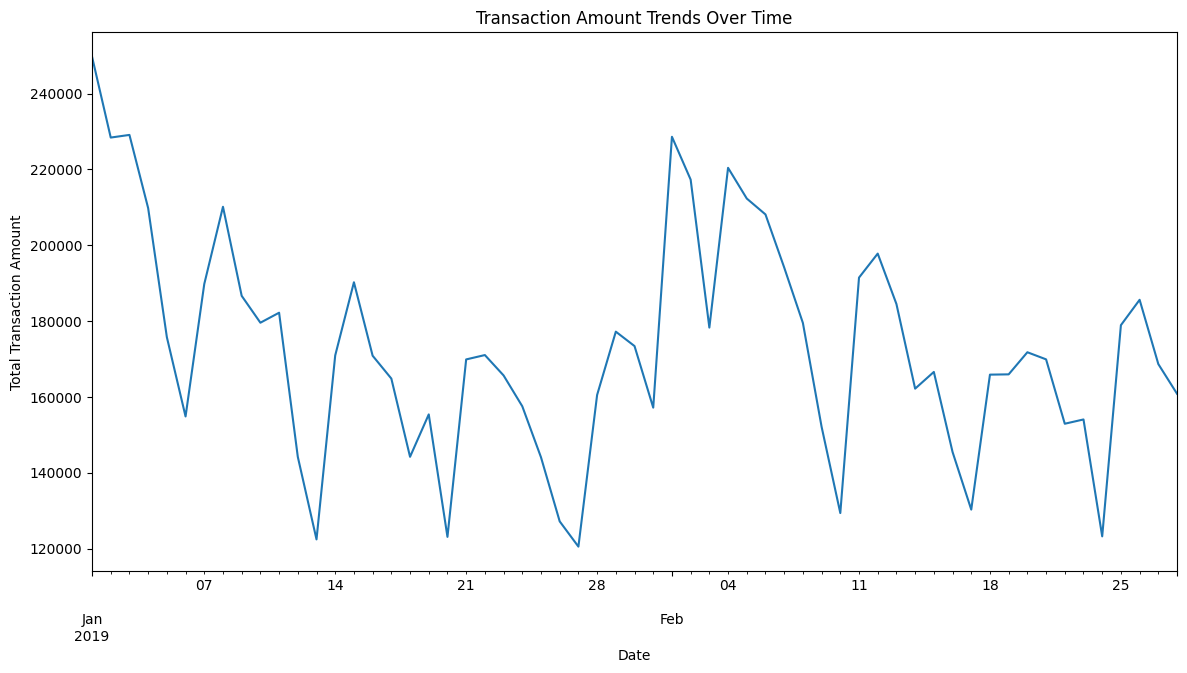

In [35]:
# Plot Transaction amount trends over time
plt.figure(figsize=(14, 7))
data.set_index('tmsp').resample('D')['amount'].sum().plot()
plt.title('Transaction Amount Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Total Transaction Amount')
plt.show()

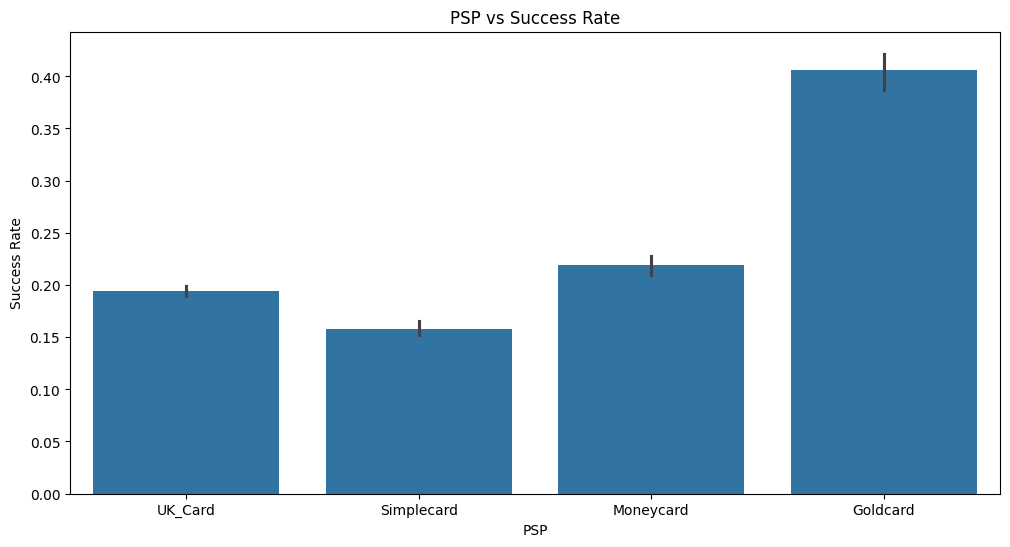

In [38]:
# PSP vs success rate (bar plot)
plt.figure(figsize=(12, 6))
sns.barplot(x='PSP', y='success', data=data, estimator=lambda x: sum(x==1) / len(x))
plt.title('PSP vs Success Rate')
plt.xlabel('PSP')
plt.ylabel('Success Rate')
plt.show()

In [39]:
data.columns

Index(['tmsp', 'country', 'amount', 'success', 'PSP', '3D_secured', 'card',
       'success_rate', 'week_of_month', 'high_amount', 'hour', 'is_weekend',
       'is_high_success_country', 'transaction_hour', 'amount_category',
       'transaction_fee', 'weekday', 'secured_success_rate_of_card',
       'country_psp_success_rate', 'uk_card_germany_successrate',
       'uk_card_Austria_successrate', 'uk_card_swiz_successrate',
       'simplecard_germany_successrate', 'simplecard_austria_successrate',
       'simplecard_swiz_successrate', 'moneycard_germany_successrate',
       'moneycard_Austria_successrate', 'moneycard_swiz_successrate',
       'secured_success_rate'],
      dtype='object')

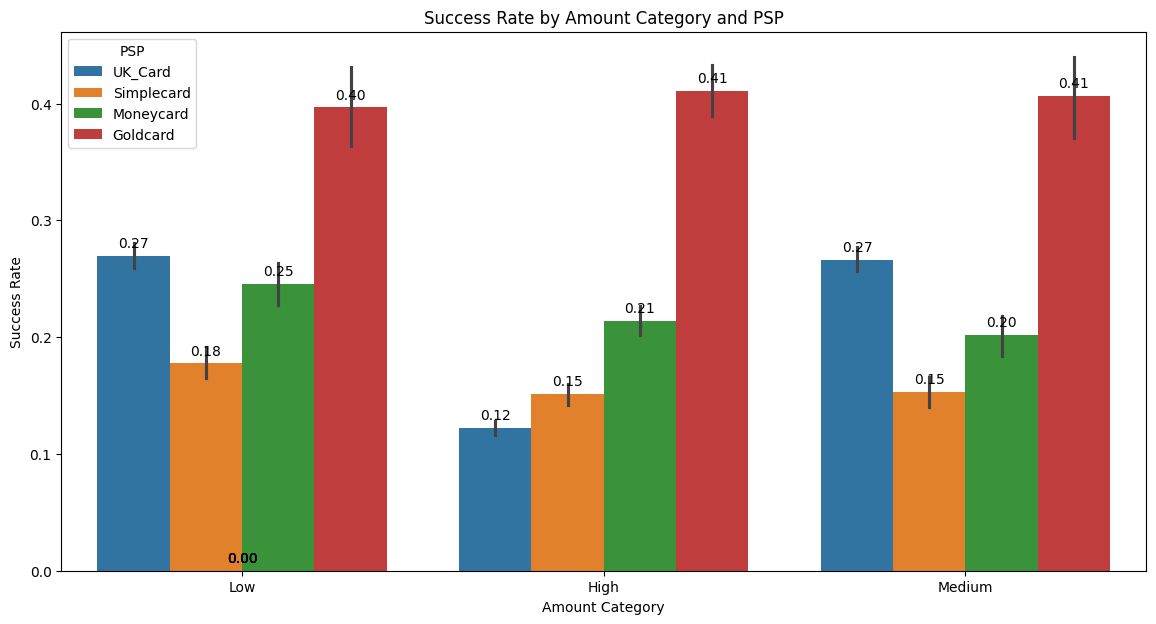

In [37]:
# Group by PSP and plot the success rate with respect to amount category
plt.figure(figsize=(14, 7))
ax = sns.barplot(x='amount_category', y='success', hue='PSP', data=data, estimator=lambda x: sum(x==1) / len(x))

# Annotate the bars with the success rate values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.title('Success Rate by Amount Category and PSP')
plt.xlabel('Amount Category')
plt.ylabel('Success Rate')
plt.legend(title='PSP')
plt.show()

In [38]:
data['transaction_hour'].unique()

array(['Midnight', 'Morning', 'Afternoon', 'Evening'], dtype=object)

In [39]:
# Count the transactions according to transaction hour
transaction_hour_count = data['transaction_hour'].value_counts().reset_index()
transaction_hour_count.columns = ['transaction_hour', 'transaction_count']

# Display the transaction count by transaction hour
print(transaction_hour_count)

  transaction_hour  transaction_count
0        Afternoon              12674
1         Midnight              12651
2          Evening              12548
3          Morning              12537


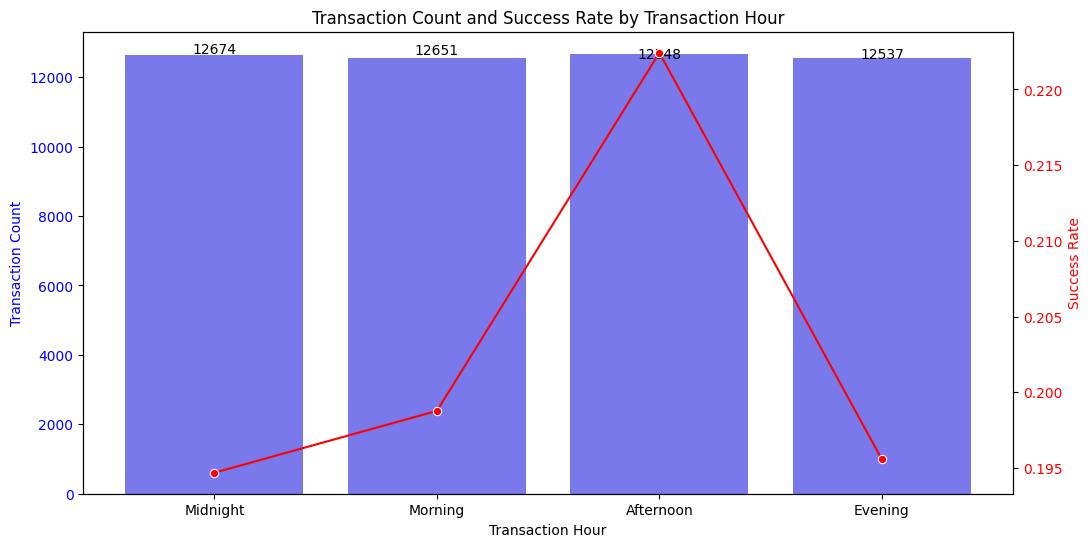

In [40]:
# Calculate the transaction count for each transaction hour
transaction_hour_count = data['transaction_hour'].value_counts().reset_index()
transaction_hour_count.columns = ['transaction_hour', 'transaction_count']

# Calculate the success rate for each transaction hour
transaction_hour_success_rate = data.groupby('transaction_hour')['success'].mean().reset_index()

# Merge the transaction count with the success rate
transaction_hour_data = pd.merge(transaction_hour_count, transaction_hour_success_rate, on='transaction_hour')

# Sort the data by transaction hour order
transaction_hour_order = ['Midnight', 'Morning', 'Afternoon', 'Evening']
transaction_hour_data['transaction_hour'] = pd.Categorical(transaction_hour_data['transaction_hour'], categories=transaction_hour_order, ordered=True)
transaction_hour_data = transaction_hour_data.sort_values('transaction_hour')

# Plot the transaction count and success rate
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot transaction count
sns.barplot(x='transaction_hour', y='transaction_count', data=transaction_hour_data, ax=ax1, color='b', alpha=0.6)
ax1.set_xlabel('Transaction Hour')
ax1.set_ylabel('Transaction Count', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Annotate the transaction count on the bar plot
for index, row in transaction_hour_data.iterrows():
    ax1.text(row.name, row.transaction_count, row.transaction_count, color='black', ha="center")

# Create a secondary y-axis to plot the success rate
ax2 = ax1.twinx()
sns.lineplot(x='transaction_hour', y='success', data=transaction_hour_data, ax=ax2, color='r', marker='o')
ax2.set_ylabel('Success Rate', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Transaction Count and Success Rate by Transaction Hour')
plt.show()

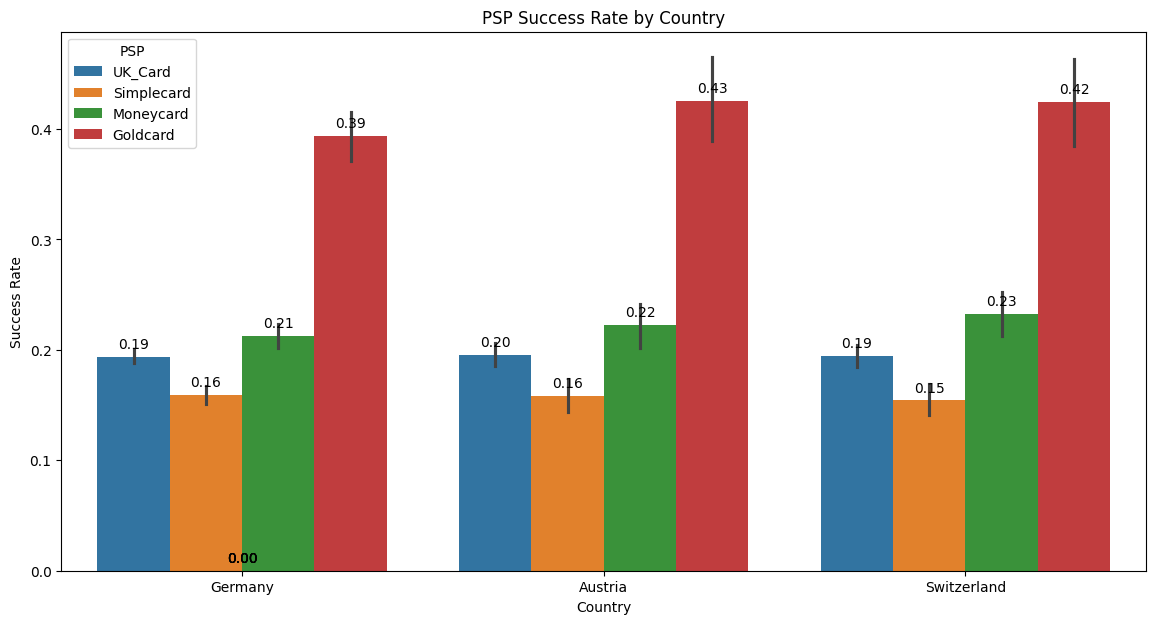

In [41]:
# Plot PSP success rate based on country and print the numbers on the graph
plt.figure(figsize=(14, 7))
ax = sns.barplot(x='country',  y='success', hue='PSP', data=data, estimator=lambda x: sum(x==1) / len(x))

# Annotate the bars with the success rate values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.title('PSP Success Rate by Country')
plt.xlabel('Country')
plt.ylabel('Success Rate')
plt.legend(title='PSP')
plt.show()

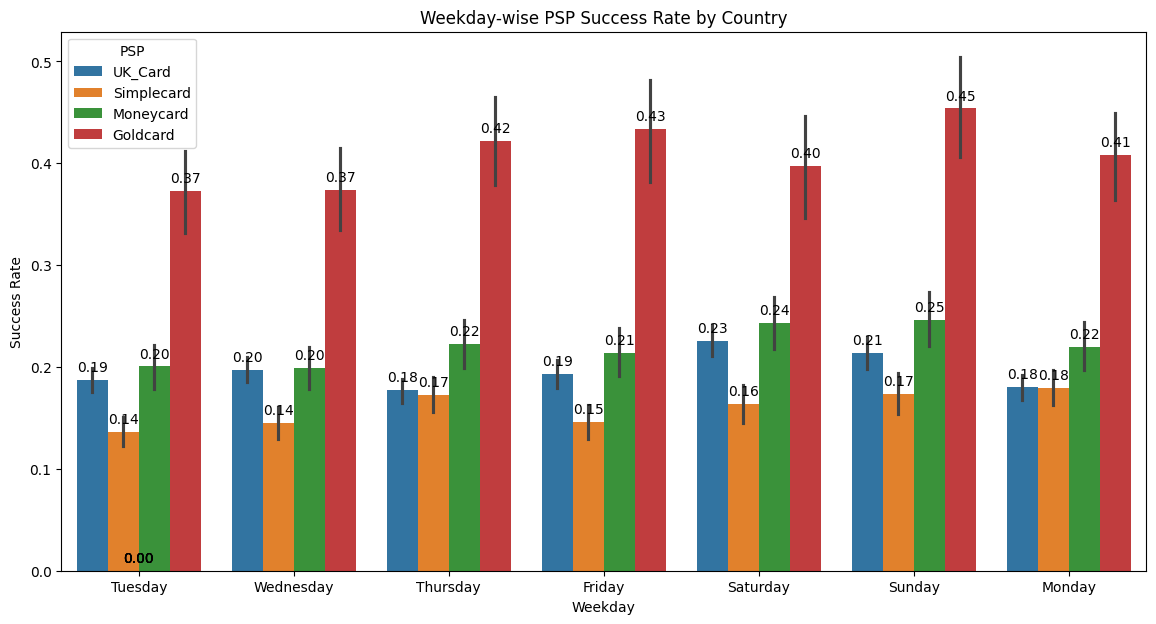

In [42]:
# Plot weekday-wise success rate of PSP with respect to country and annotate the success rate numbers on the graph
plt.figure(figsize=(14, 7))
ax = sns.barplot(x='weekday', y='success', hue='PSP', data=data, estimator=lambda x: sum(x==1) / len(x))

# Annotate the bars with the success rate values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.title('Weekday-wise PSP Success Rate by Country')
plt.xlabel('Weekday')
plt.ylabel('Success Rate')
plt.legend(title='PSP')
plt.show()

<Figure size 1400x700 with 0 Axes>

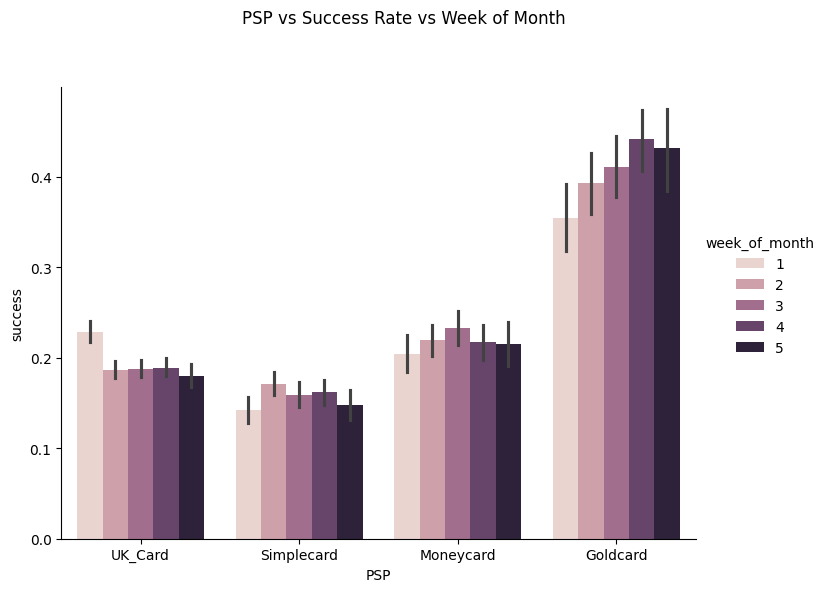

In [47]:
# Plot PSP vs Success Rate vs Week of Month
plt.figure(figsize=(14, 7))
sns.catplot(x='PSP', y='success', hue='week_of_month', data=data, kind='bar', estimator=lambda x: sum(x==1) / len(x), height=6, aspect=1.2)
plt.subplots_adjust(top=0.85)
plt.suptitle('PSP vs Success Rate vs Week of Month')
plt.show()

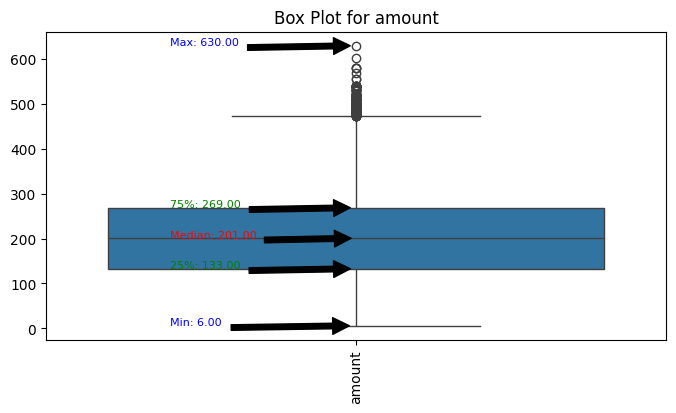

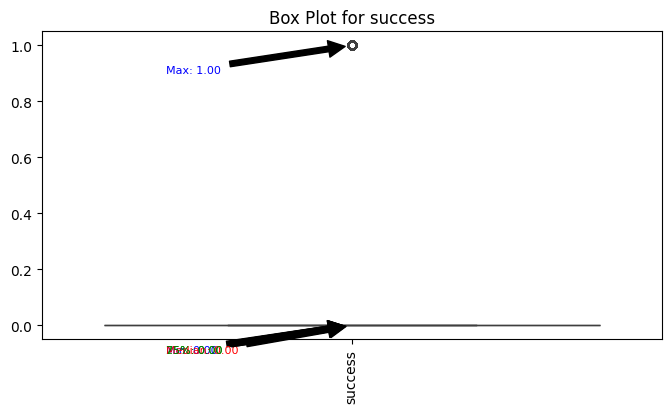

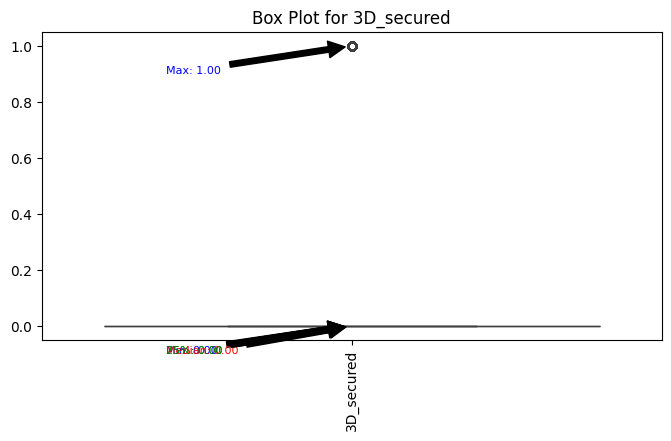

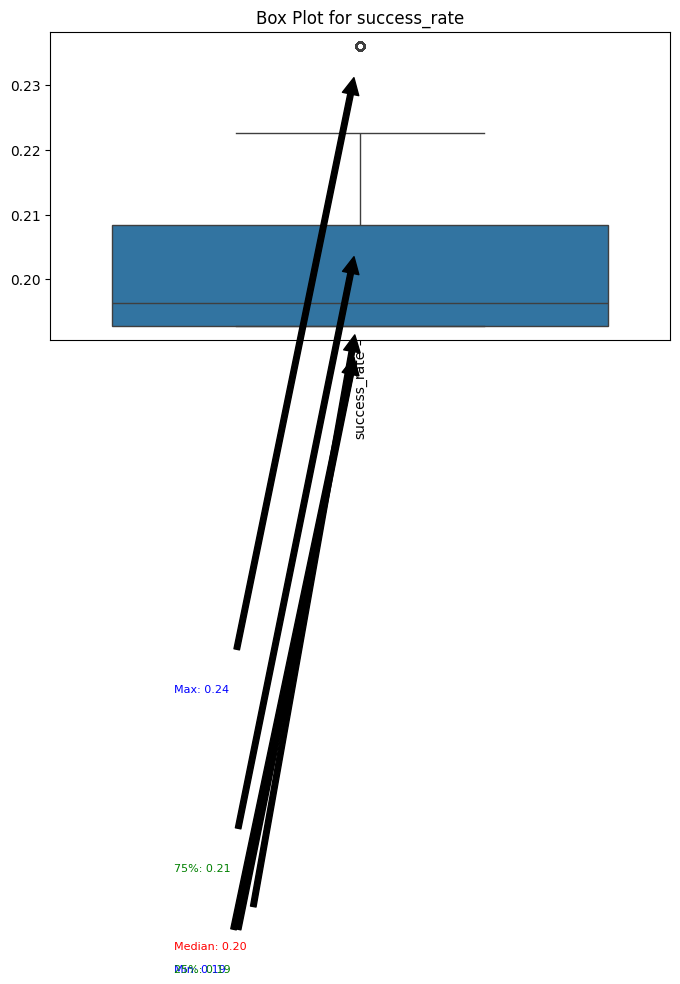

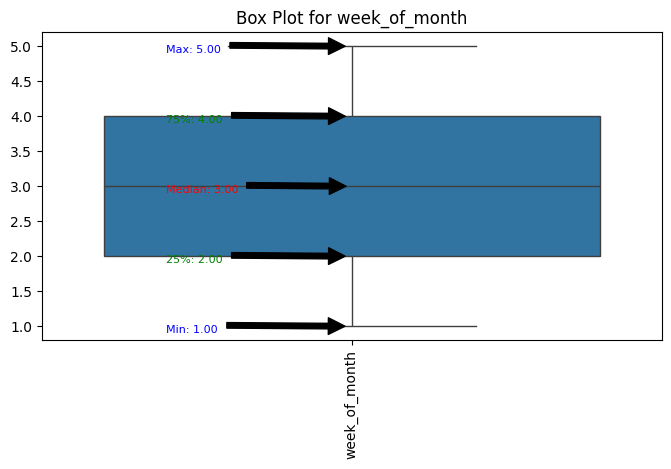

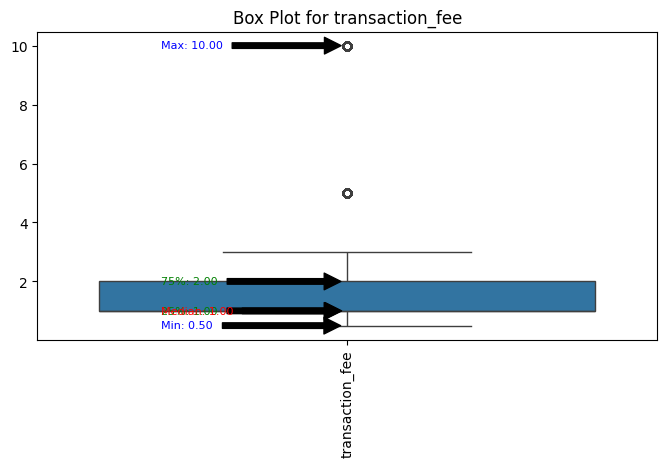

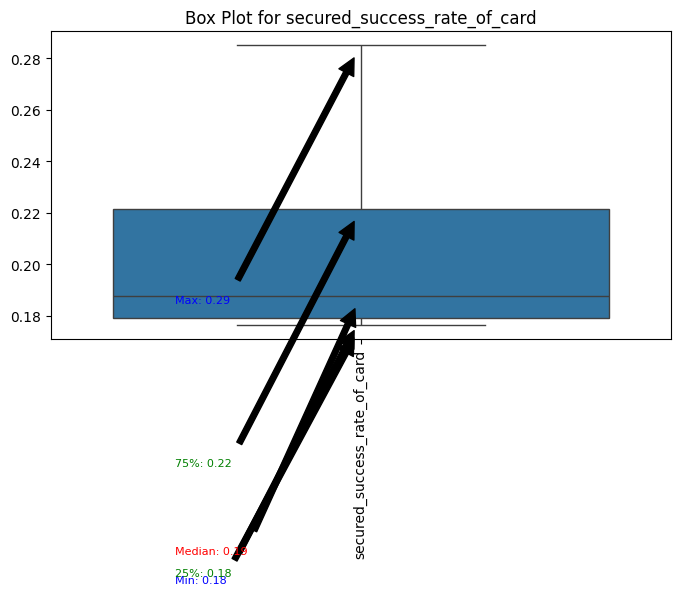

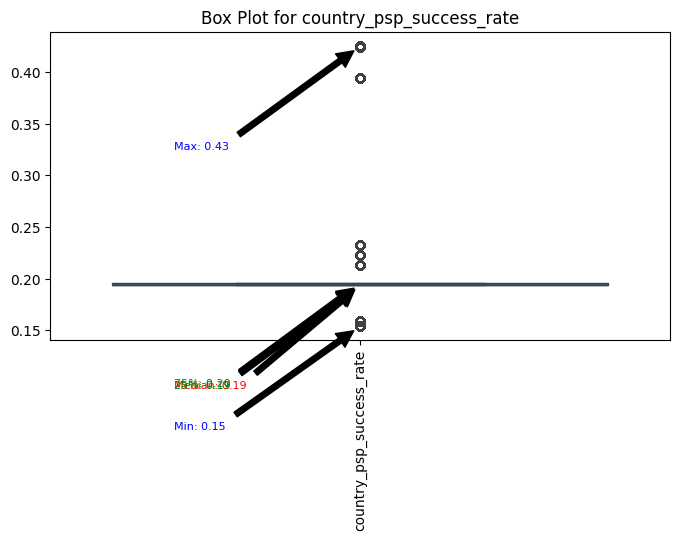

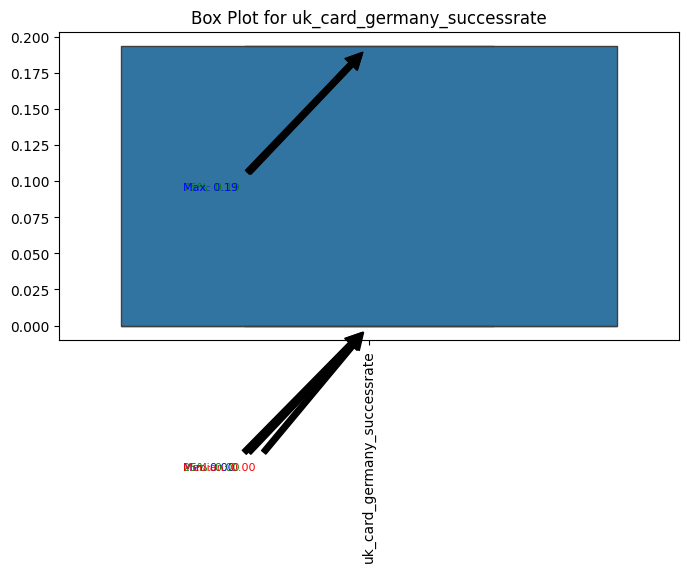

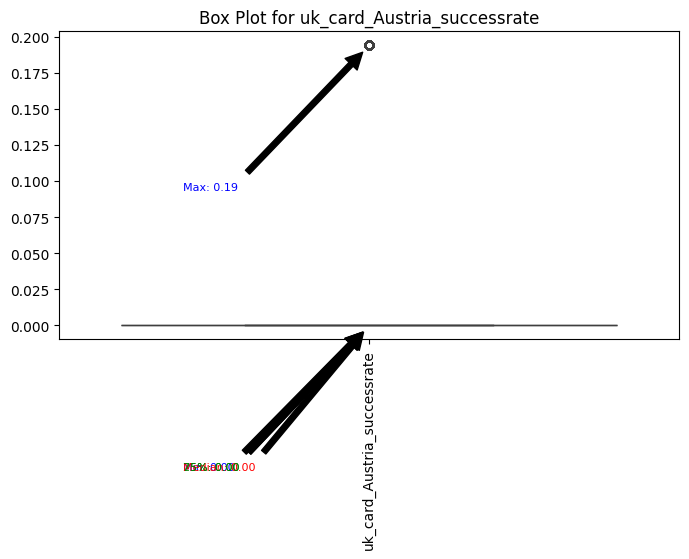

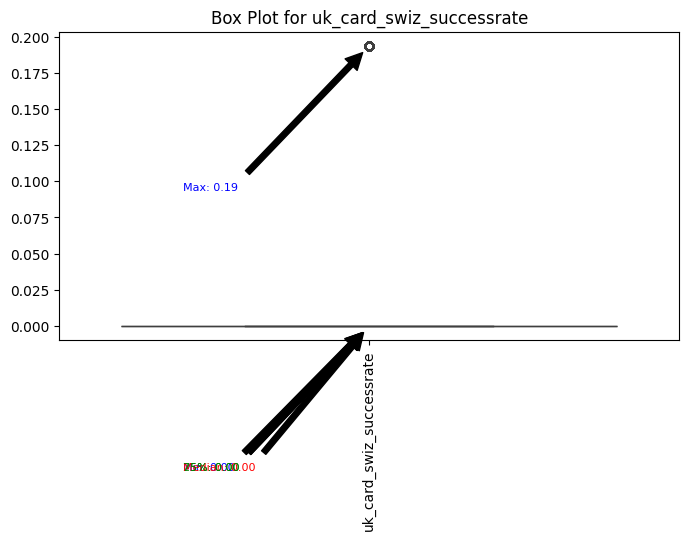

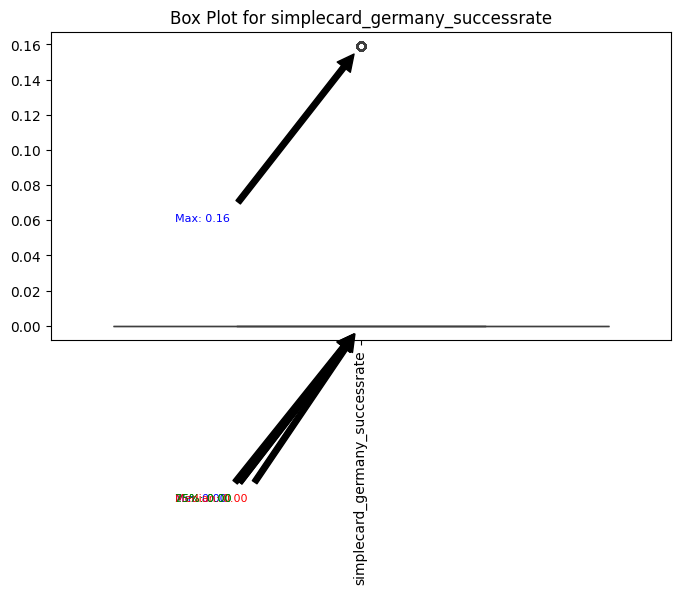

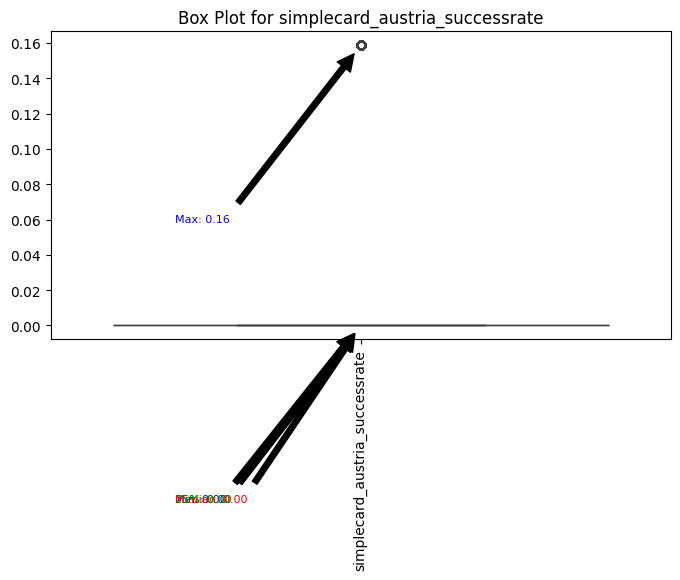

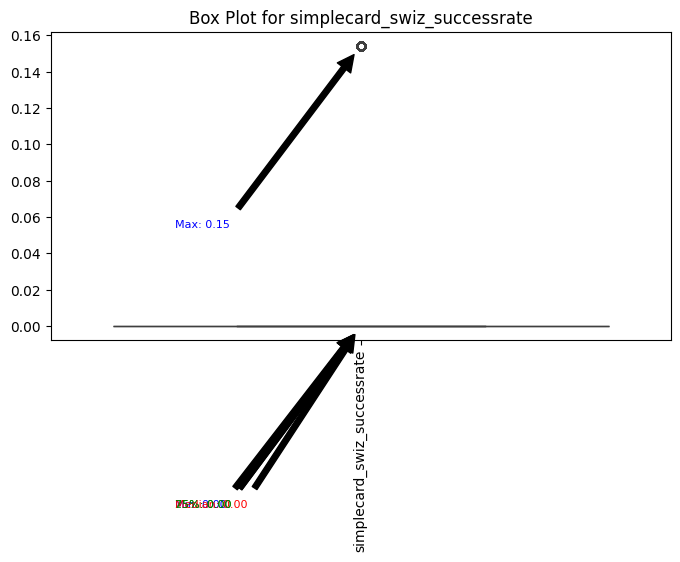

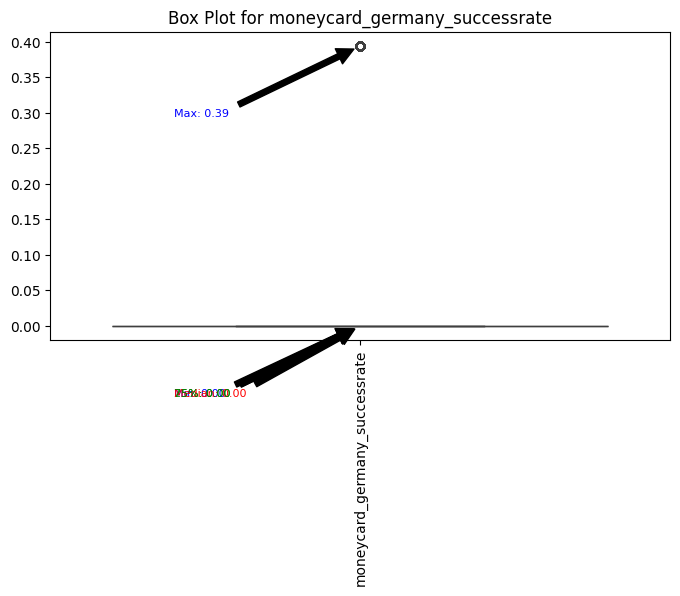

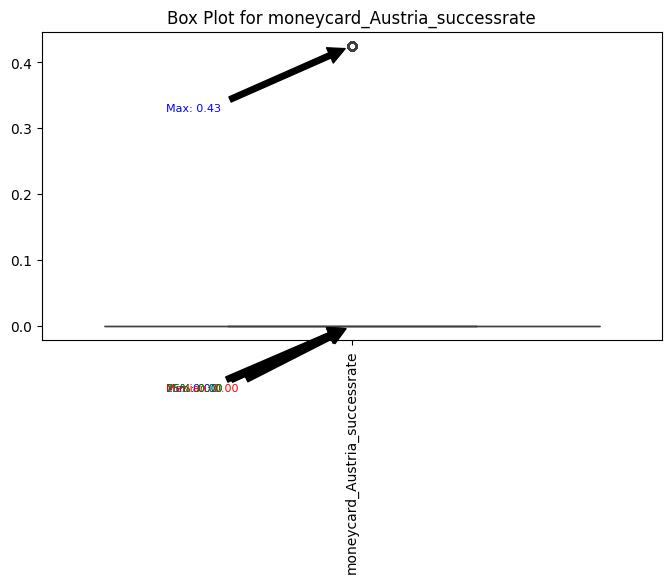

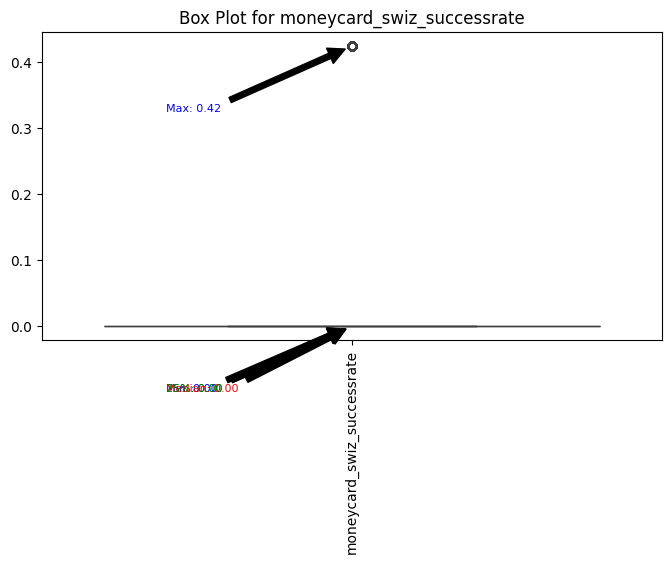

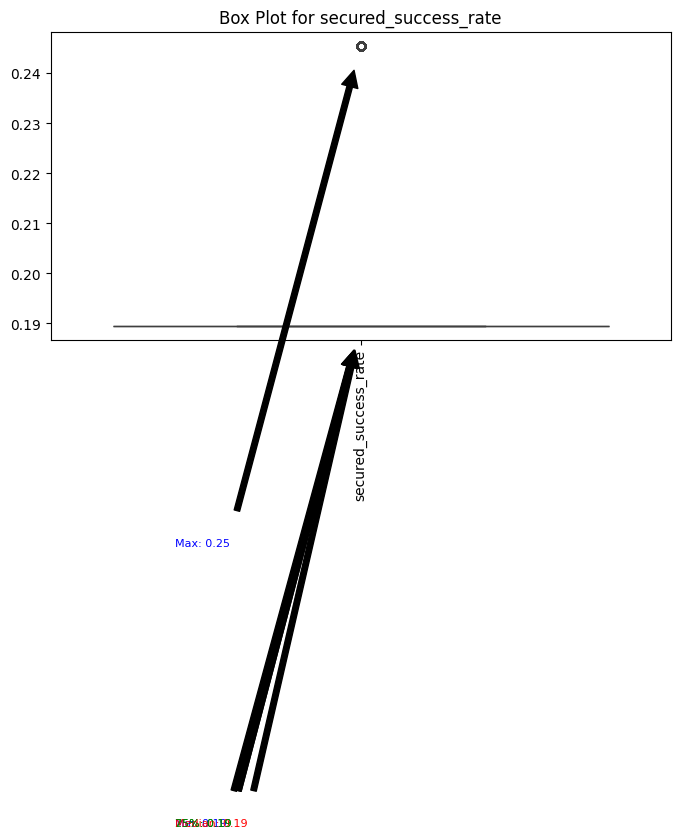

In [49]:
# Get the numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Plot the box plot for each numerical column separately
for column in numerical_columns:
    plt.figure(figsize=(8, 4))
    ax = sns.boxplot(data=data[[column]])
    plt.title(f'Box Plot for {column}')
    plt.xticks(rotation=90)

    # Annotate the box plot with min, 25th percentile, median, 75th percentile, and max values
    column_data = data[column].dropna()
    min_val = column_data.min()
    q1 = column_data.quantile(0.25)
    median = column_data.median()
    q3 = column_data.quantile(0.75)
    max_val = column_data.max()

    # Annotate each box plot
    ax.annotate(f'Min: {min_val:.2f}', xy=(0, min_val), xytext=(-0.3, min_val-0.1), 
                arrowprops=dict(facecolor='black', shrink=0.05), fontsize=8, color='blue')
    ax.annotate(f'25%: {q1:.2f}', xy=(0, q1), xytext=(-0.3, q1-0.1), 
                arrowprops=dict(facecolor='black', shrink=0.05), fontsize=8, color='green')
    ax.annotate(f'Median: {median:.2f}', xy=(0, median), xytext=(-0.3, median-0.1), 
                arrowprops=dict(facecolor='black', shrink=0.05), fontsize=8, color='red')
    ax.annotate(f'75%: {q3:.2f}', xy=(0, q3), xytext=(-0.3, q3-0.1), 
                arrowprops=dict(facecolor='black', shrink=0.05), fontsize=8, color='green')
    ax.annotate(f'Max: {max_val:.2f}', xy=(0, max_val), xytext=(-0.3, max_val-0.1), 
                arrowprops=dict(facecolor='black', shrink=0.05), fontsize=8, color='blue')

    plt.show()

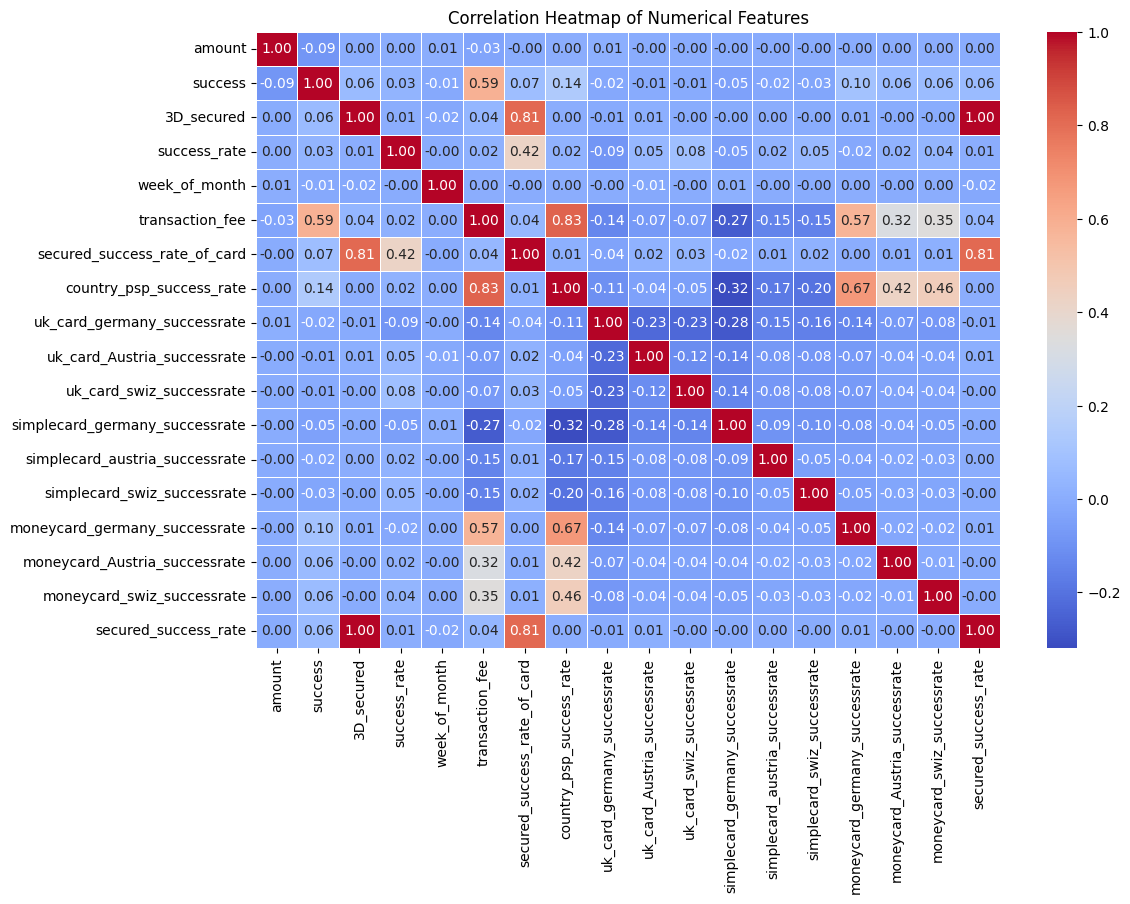

In [50]:
# Get the numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

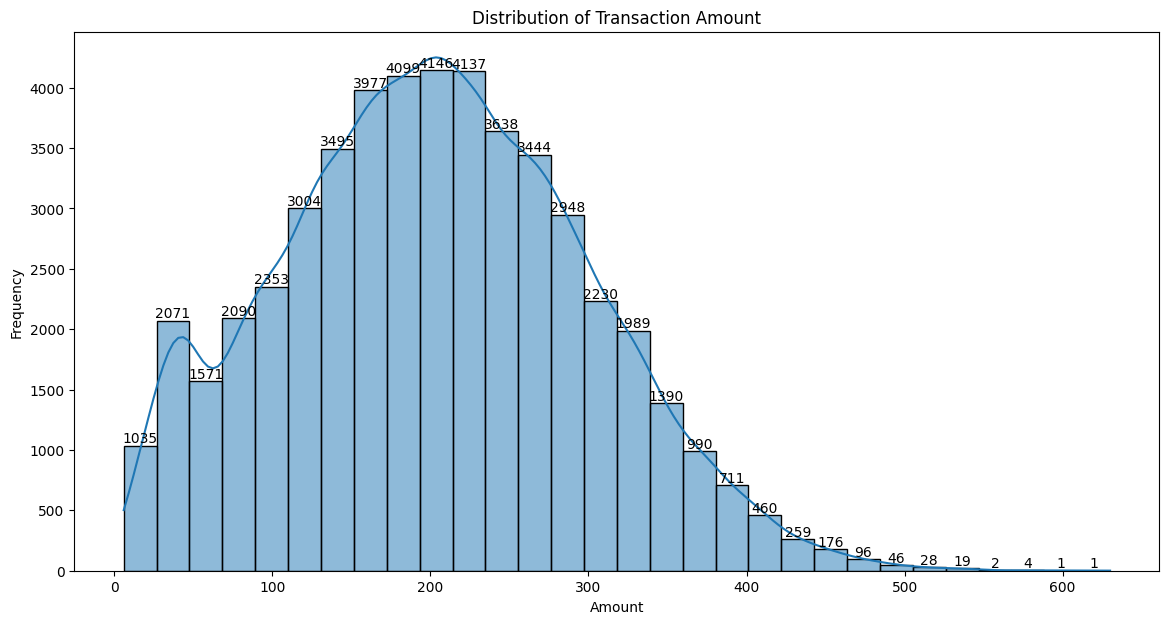

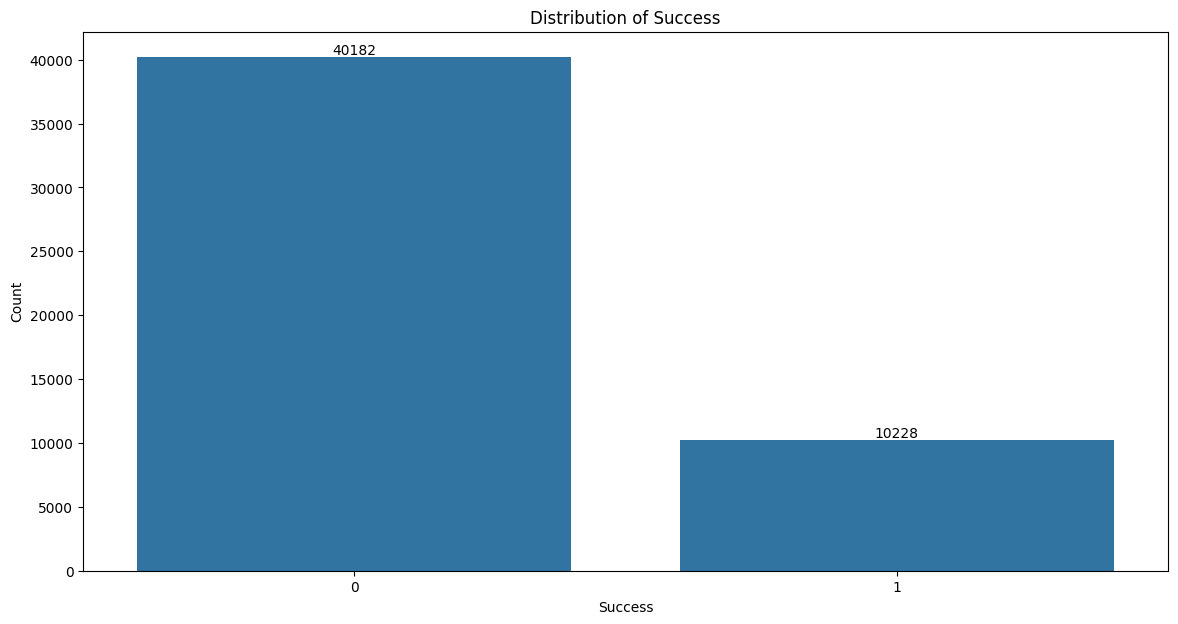

In [52]:
# Plot the distribution of 'amount' and 'success' columns and print the numbers on the graph

# Plot the distribution of 'amount'
plt.figure(figsize=(14, 7))
ax = sns.histplot(data['amount'], bins=30, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount')
plt.ylabel('Frequency')

# Annotate the histogram with the count of each bin
for p in ax.patches:
    height = p.get_height()
    plt.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

# Plot the distribution of 'success'
plt.figure(figsize=(14, 7))
ax = sns.countplot(x='success', data=data)
plt.title('Distribution of Success')
plt.xlabel('Success')
plt.ylabel('Count')

# Annotate the count plot with the count of each category
for p in ax.patches:
    height = p.get_height()
    plt.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()